In [68]:
#install unzip in notebook
!sudo apt-get install -y unzip zip


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  unzip zip
0 upgraded, 2 newly installed, 0 to remove and 50 not upgraded.
Need to get 335 kB of archives.
After this operation, 1231 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 unzip amd64 6.0-25ubuntu1.1 [168 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/main amd64 zip amd64 3.0-11build1 [167 kB]
Fetched 335 kB in 0s (2045 kB/s)
debconf: delaying package configuration, since apt-utils is not installed
Selecting previously unselected package unzip.
(Reading database ... 25583 files and directories currently installed.)
Preparing to unpack .../unzip_6.0-25ubuntu1.1_amd64.deb ...
Unpacking unzip (6.0-25ubuntu1.1) ...
Selecting previously unselected package zip.
Preparing to unpack .../zip_3.0-11build1_amd64.deb ...
Unpacking zip (3.0-11build1) ...
Setting up unzip (6.0-25ubuntu1.1) 

In [69]:
!pip install boto3 datasets


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [70]:
import boto3

s3 = boto3.resource('s3', endpoint_url='https://storage.s3.mlops.wogra.com')
bucket = s3.Bucket('data')

In [71]:
bucket.download_file('dlr/dataset_tapelegen.zip', 'data.zip')

In [72]:
# extreact zip file to data folder
!rm -r data
!unzip data.zip -d data

Archive:  data.zip
   creating: data/dataset_tapelegen/
  inflating: data/dataset_tapelegen/dataset_info.json  
  inflating: data/dataset_tapelegen/data-00001-of-00003.arrow  
  inflating: data/dataset_tapelegen/state.json  
  inflating: data/dataset_tapelegen/data-00000-of-00003.arrow  
  inflating: data/dataset_tapelegen/data-00002-of-00003.arrow  
 extracting: data/dataset_tapelegen/dataset_dict.json  
   creating: data/dataset_tapelegen/train/
  inflating: data/dataset_tapelegen/train/dataset_info.json  
  inflating: data/dataset_tapelegen/train/data-00001-of-00003.arrow  
  inflating: data/dataset_tapelegen/train/state.json  
  inflating: data/dataset_tapelegen/train/data-00000-of-00003.arrow  
  inflating: data/dataset_tapelegen/train/data-00002-of-00003.arrow  


In [73]:
# create a dataset for images in the folders and use the folder name as label
from datasets import load_from_disk

dataset = load_from_disk("data/dataset_tapelegen/")
dataset


Dataset({
    features: ['image', 'label'],
    num_rows: 73749
})

In [74]:
import numpy as np

# Function that transforms a PIL.TiffImagePlugin.TiffImageFile into a numpy array and return mean of pixel values and standard deveation
def compute_mean(image):
    image = np.array(image)
    return np.mean(image)

def compute_std(image):
    image = np.array(image)
    return np.std(image)

def add_mean_and_std(example):
    example["mean"] = compute_mean(example["image"])
    example["std"] = compute_std(example["image"])
    return example

dataset_mean_std = dataset.map(add_mean_and_std, num_proc=8)

/home/ray/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


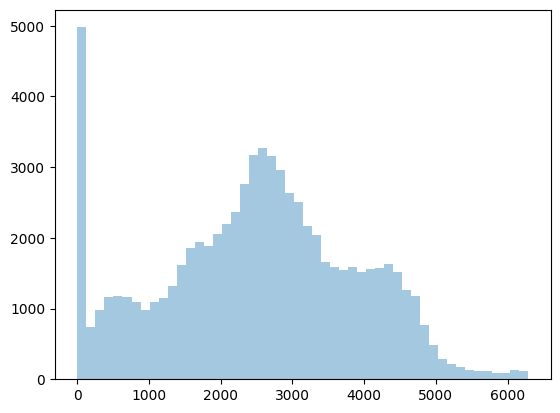

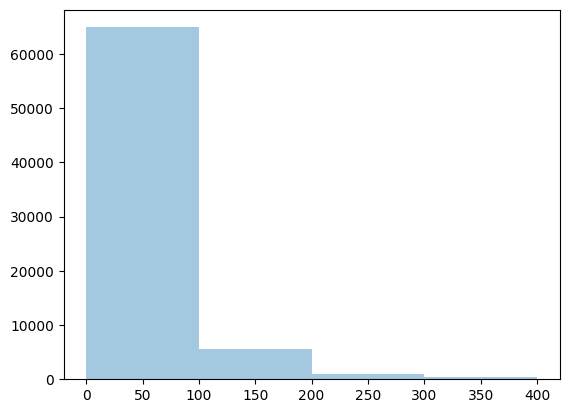

In [75]:
# make an sns distplot of dataset mean and std
import seaborn as sns
import matplotlib.pyplot as plt

sns.distplot(dataset_mean_std["mean"], kde=False)
plt.show()

# this distplot shall only show the std from 0 to 500 with a bin size of 100
sns.distplot(dataset_mean_std["std"], kde=False, bins=range(0, 500, 100))
plt.show()



In [76]:
# make a list with ids of all dataset items with mean 0
ids_with_mean_0 = [i for i, x in enumerate(dataset_mean_std["mean"]) if x == 0]

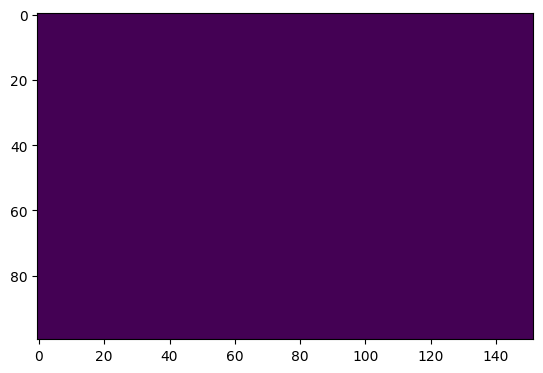

In [77]:
import matplotlib.pyplot as plt
import numpy as np
img_array = np.array(dataset[ids_with_mean_0[0]]['image'])
plt.imshow(img_array)
plt.show()

In [78]:
np.size(ids_with_mean_0)

1462

In [79]:
# remove all items from dataset with mean 0 but dont use remove rows which not exists as method

clean_dataset = dataset_mean_std.filter(lambda example: example["mean"] != 0)

In [80]:
# A Function that transforms a PIL.TiffImagePlugin.TiffImageFile into a numpy array and then substract the mean and divide by the standard deviation
def normalize(example):
    image = np.array(example)
    mean = np.mean(image)
    #substract mean from image
    image = image - mean + 128
    #all valuaes below 0 are set to 0
    image[image < 0] = 0
    #all values above 255 are set to 255
    image[image > 255] = 255
    #all values are divided by 255
    image = image / 255
    return image

def add_normalized_image(example):
    example["normalized_image"] = normalize(example["image"])
    return example

normalized_dataset = clean_dataset.map(add_normalized_image, num_proc=8)

In [81]:
normalized_dataset

Dataset({
    features: ['image', 'label', 'mean', 'std', 'normalized_image'],
    num_rows: 72287
})

In [82]:
# I need a list of 10 random ids 10 examples and I want at least 2 examples of each label in this list
import random
random.seed(42)
random_ids = random.sample(range(0, len(normalized_dataset)), 10)
random_ids


[14592, 3278, 36048, 32098, 29256, 18289, 13434, 71482, 11395, 55302]

In [83]:
#print labels for ids
[normalized_dataset[i]['label'] for i in random_ids]

[1, 0, 1, 1, 1, 1, 1, 2, 1, 1]

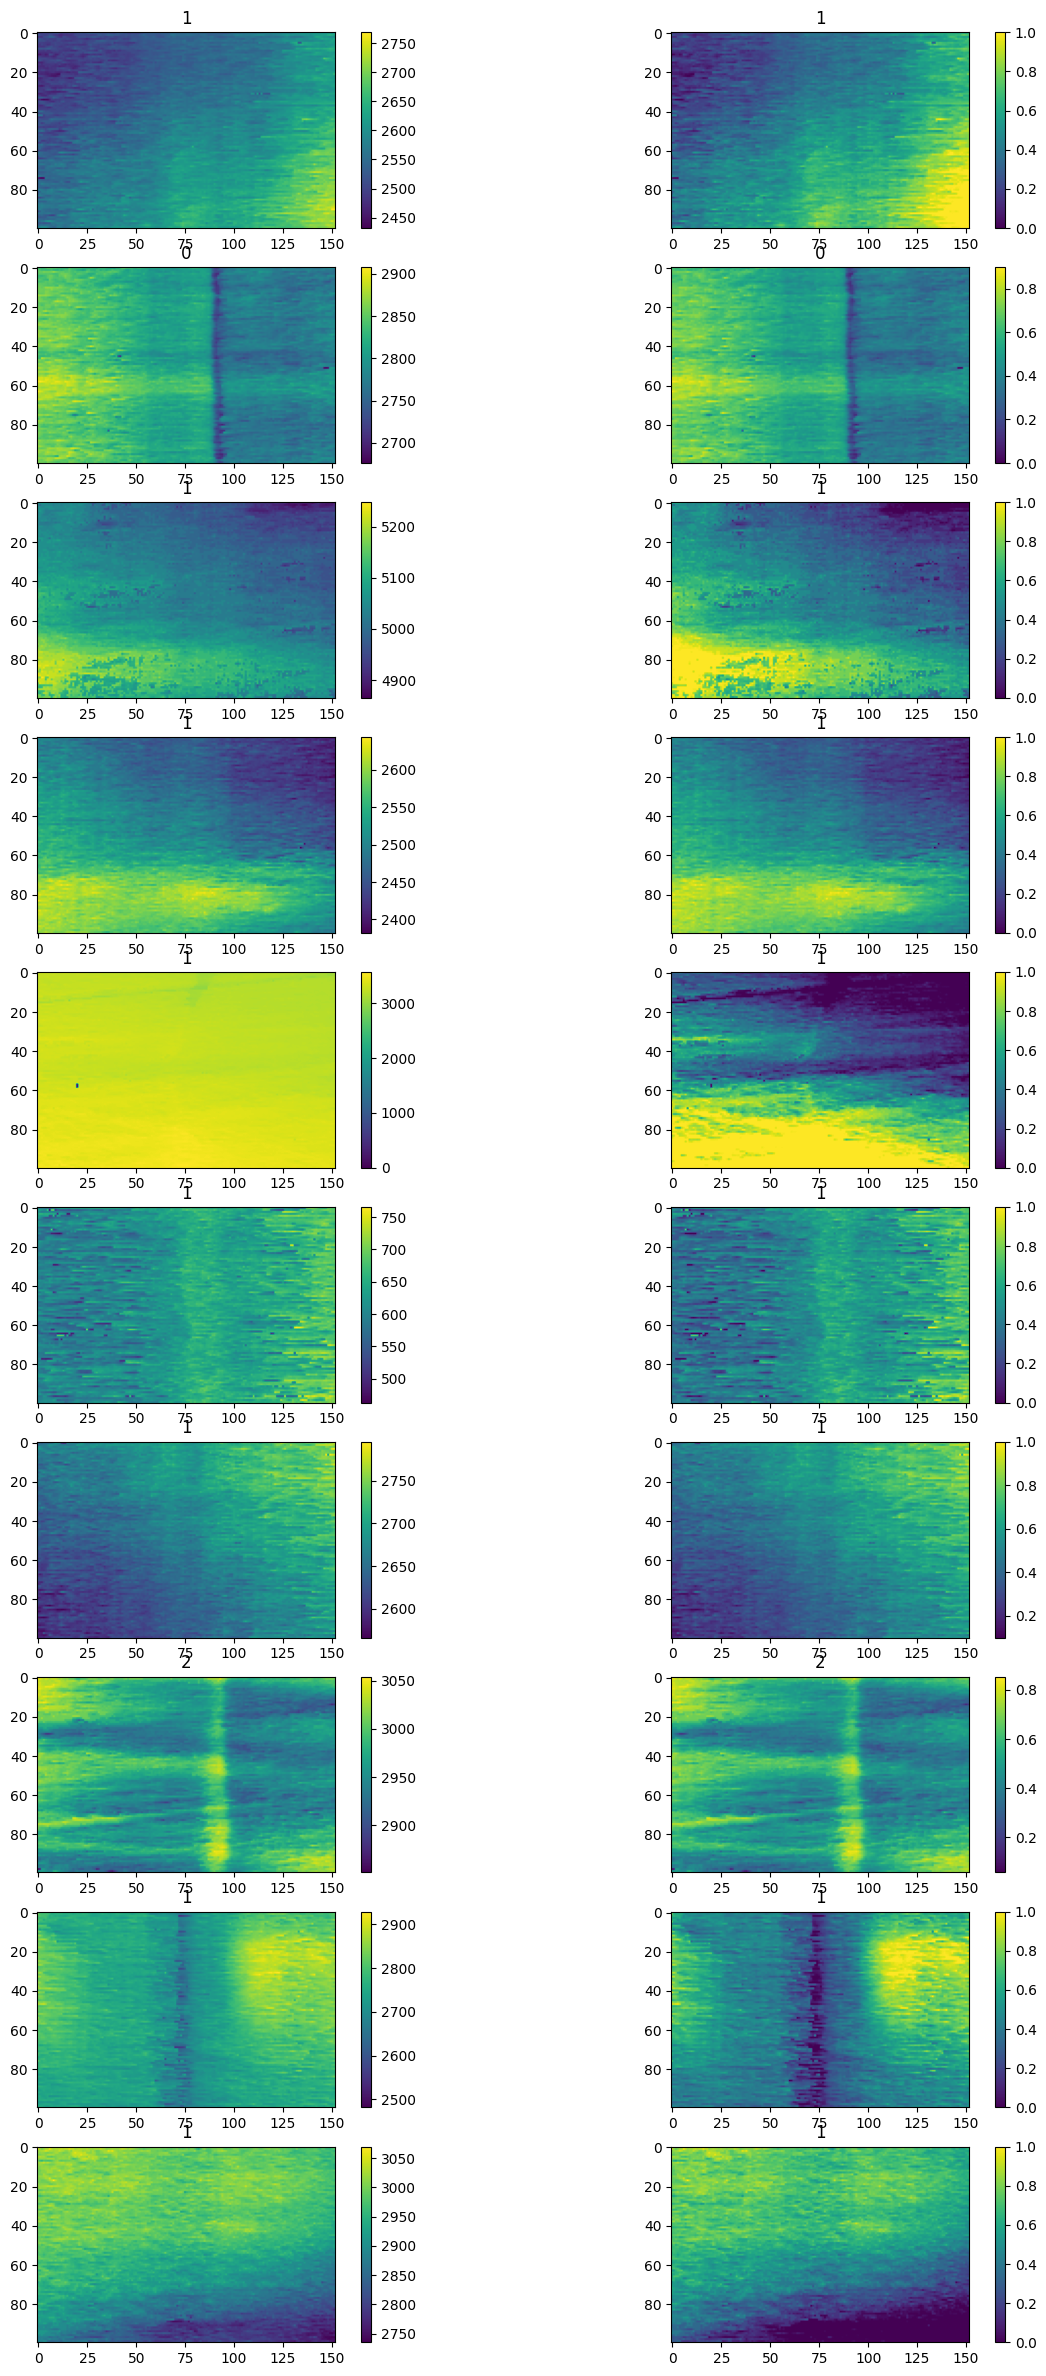

In [84]:
# OK. now the same thing as before but please provide the labels as title of each image

import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(10, 2, figsize=(15, 30))

# Plotting the images and adding color bar
for i, j in zip(range(10), random_ids):
    img_array = np.array(normalized_dataset[j]['image'])
    img = axs[i, 0].imshow(img_array)
    axs[i, 0].set_title(normalized_dataset[j]['label'])
    axs[i, 0].figure.colorbar(img, ax=axs[i, 0])
    
    img_array = np.array(normalized_dataset[j]['normalized_image'])
    img = axs[i, 1].imshow(img_array)
    axs[i, 1].set_title(normalized_dataset[j]['label'])
    axs[i, 1].figure.colorbar(img, ax=axs[i, 1])

plt.show()

In [85]:
pip install transformers==4.26.1 


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [86]:
import transformers

model_name_or_path = "google/vit-base-patch16-224-in21k"

feature_extractor = transformers.AutoFeatureExtractor.from_pretrained(
    model_name_or_path
)

print(feature_extractor.size)
print(feature_extractor.image_mean)
print(feature_extractor.image_std)

{'height': 224, 'width': 224}
[0.5, 0.5, 0.5]
[0.5, 0.5, 0.5]


/home/ray/anaconda3/lib/python3.8/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [87]:
from torchvision import transforms
import numpy as np

def preprocess(image):
    # convert image to tensor
    tensor = transforms.ToTensor()(image)
    tensor = tensor - np.mean(tensor.numpy()) + 128
    tensor[tensor < 0] = 0
    tensor[tensor > 255] = 255
    tensor = tensor / 255
    # repeat the tensor two ore times to get 3 channels and use the repeat function
    tensor = tensor.repeat(3, 1, 1)
    return tensor



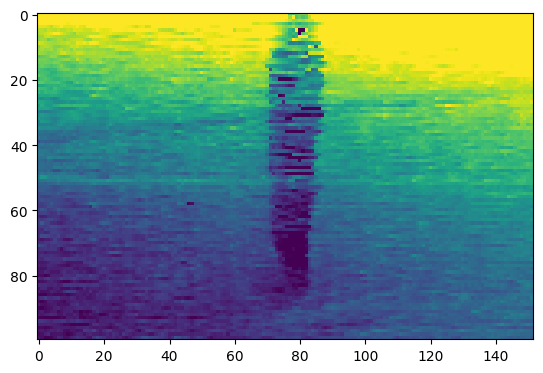

In [88]:
# take an exemplary image and preprocess it and plot it
import matplotlib.pyplot as plt
import numpy as np

img = normalized_dataset[0]['image']
tensor = preprocess(img)
plt.imshow(tensor[0])
plt.show()


In [89]:
from torchvision import transforms


class Preprocess:
    def __init__(self):
        self.transforms = transforms.Compose(
            [
                transforms.Lambda(preprocess),
                transforms.CenterCrop(224),
            ]
        )

    def __call__(self, example_batch):
        example_batch["preprocessed_image"] = [
            self.transforms(img) for img in example_batch["image"]
        ]
        return example_batch
    
normalized_dataset.set_transform(Preprocess())
normalized_dataset[0]["preprocessed_image"]

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

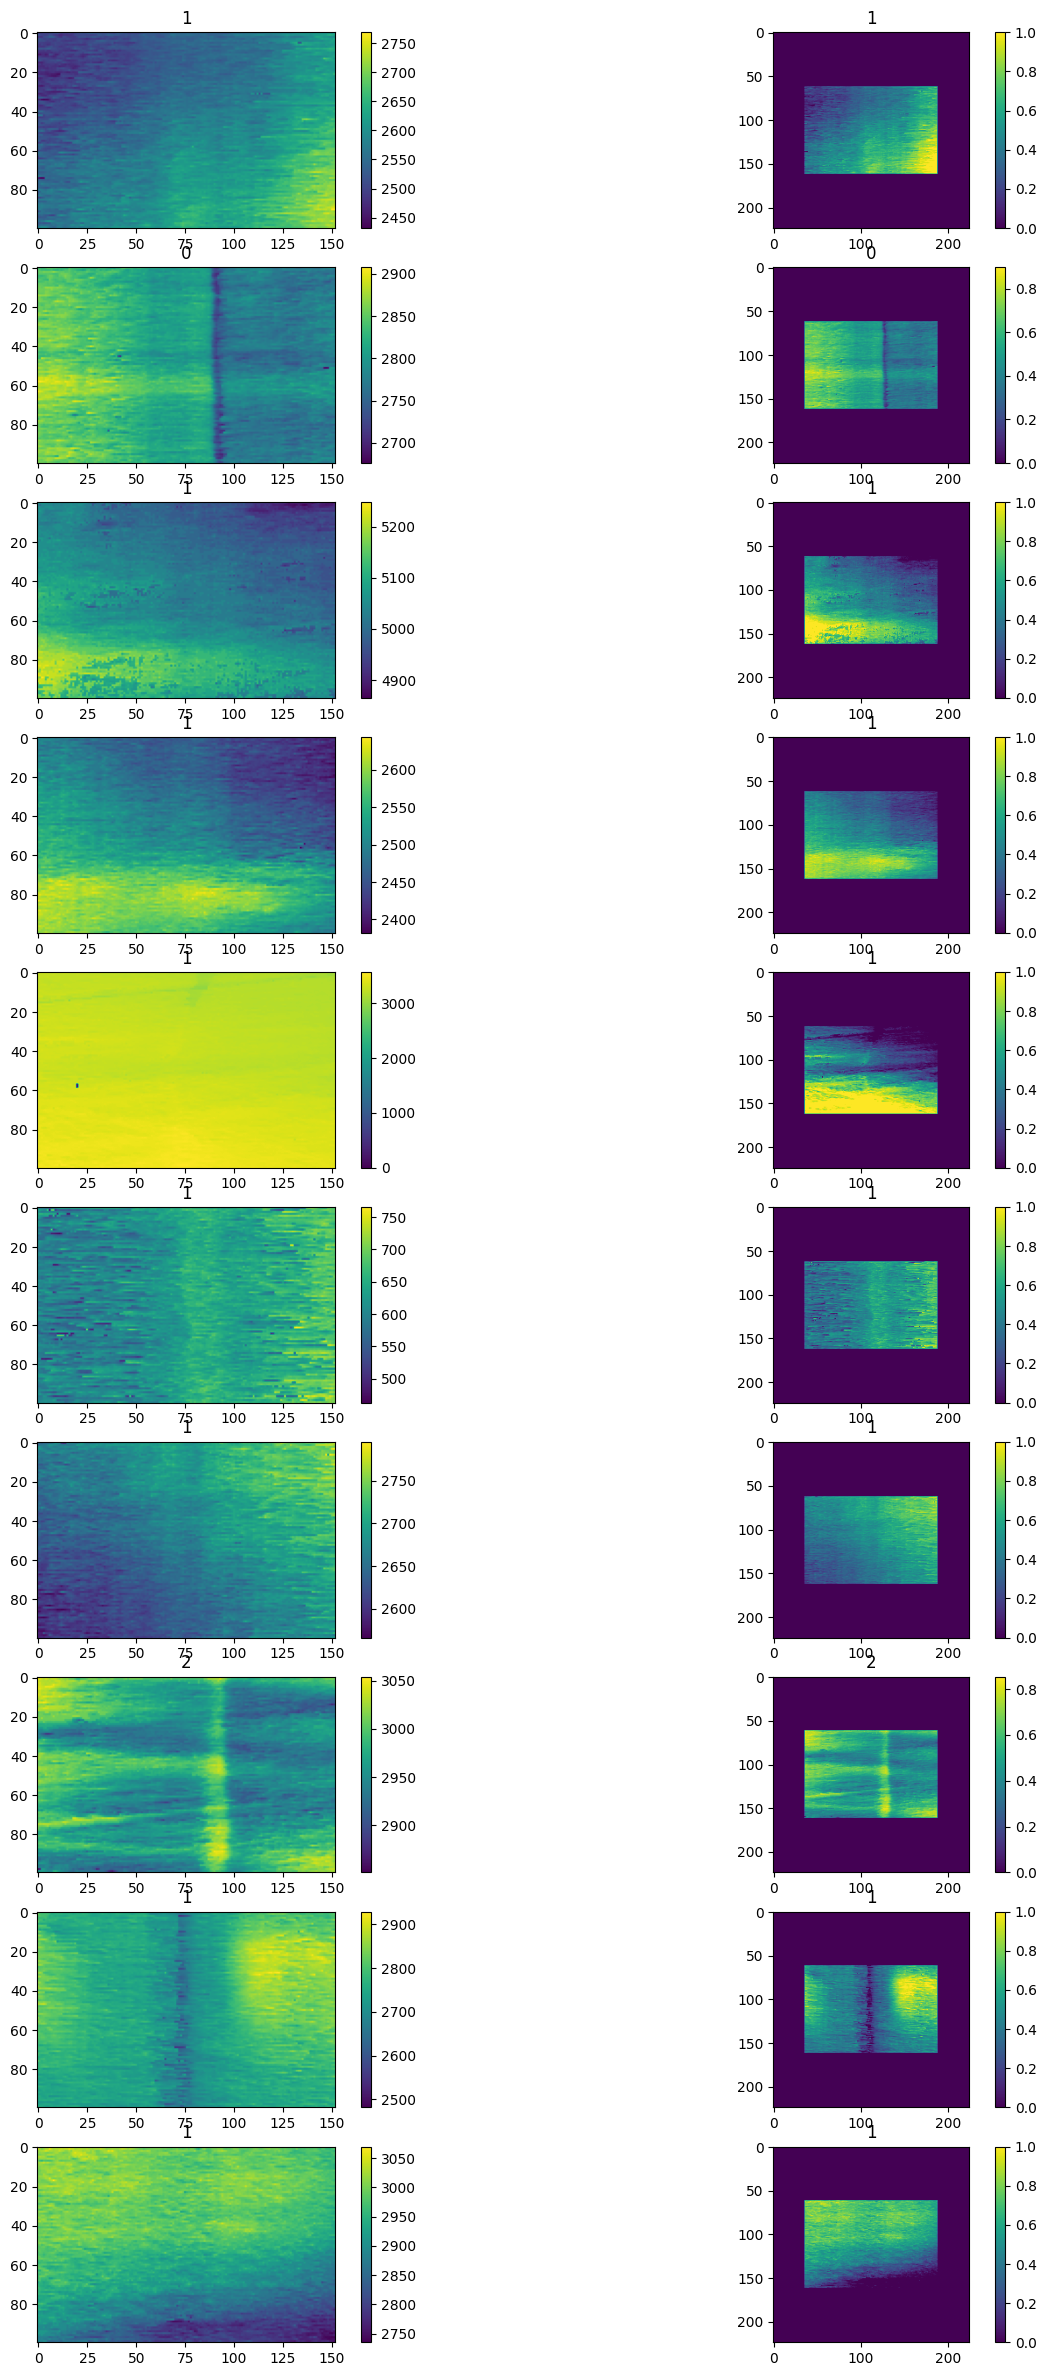

In [90]:
#plot the same images as above but dont use the normalized images but the pixel values

import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(10, 2, figsize=(15, 30))

# Plotting the images and adding color bar
for i, j in zip(range(10), random_ids):
    img_array = np.array(normalized_dataset[j]['image'])
    img = axs[i, 0].imshow(img_array)
    axs[i, 0].set_title(normalized_dataset[j]['label'])
    axs[i, 0].figure.colorbar(img, ax=axs[i, 0])
    
    img_array = np.array(normalized_dataset[j]['preprocessed_image'][0])
    img = axs[i, 1].imshow(img_array)
    axs[i, 1].set_title(normalized_dataset[j]['label'])
    axs[i, 1].figure.colorbar(img, ax=axs[i, 1])

plt.show()
